In [1]:
# import packages
import os
import sys

import logging
import h3
import numpy as np
import pandas as pd
import seaborn as sns 
from scipy import stats
from dotenv import load_dotenv, find_dotenv
from citymobil_python_clickhouse_wrapper import ClickHouseWrapper
from tabulate import tabulate
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from datetime import datetime, timedelta
import time

from scipy.stats import *
from statsmodels.stats.multitest import multipletests

import random

import plotly.graph_objects as go
import plotly.express as px

import itertools

from tqdm import tqdm 
#from citymobil_python_maxp_tools import metric_fpr, metric_fpr_bootstrap
#from citymobil_python_maxp_tools import metric_fpr, clean_boundary_h3, clean_double_users


%matplotlib inline

In [2]:
import config

ModuleNotFoundError: No module named 'config'

In [3]:
cred = pd.read_json(r'/Users/skostuchik/crd_exa.json')
user = cred.login.squeeze()
password = cred.password_exa.squeeze()

In [4]:
# creds


#chbi
logger = logging.getLogger()
clickhouse_chbi = ClickHouseWrapper(
    logger,
    url="http://chbi-vip.city-srv.ru:8123",
    user=user,
    password=password,
    create_and_assign_event_loop=False,  # for django threads with no event loop
    allow_nested_event_loops=True  # for jupyter threads with existed event loop
)

#chmain
clickhouse_chmain = ClickHouseWrapper(
    logger,
    url="http://chmain-vip.local.city-dt.ru:8123",
    user=user,
    password=password,
    create_and_assign_event_loop=False,  # for django threads with no event loop
    allow_nested_event_loops=True  # for jupyter threads with existed event loop
)

#df = clickhouse_chmain.fetch(''' ''')

#df_ex = C.export_to_pandas(''' ''')

In [5]:
#Saint Petersbourg in period without Momental Discounts

query_params = {
    "dt_start": '2021-09-14 00:00:00',
    "dt_end": '2021-09-17 00:00:00',
    "id_locality": '22534'
}

In [6]:
# load query
q_1 = """
        SELECT
          id_locality
        , id_tariff_zone
        , id_tariff_group
        , polygon_from
        , h3_6
        , dt
        , status
        , id_client
        , uniqExact(id_client)                                               views
        , uniqExactIf(id_order, id_order > 0)                                orders
        , uniqExactIf(id_order, id_order > 0 AND status NOT IN ('CC', 'NC')) rides
        , sumIf(client_bill, status = 'CP')                                  client_bill

        , sum(commission_total_amt/1.2 - di_total_amt - ci_total_amt)        contribution
    FROM (
         SELECT id_order
              , id_locality
              , id_tariff_zone
              , id_tariff_group
              , polygon_from
              , h3_6
              , toStartOfInterval(calculated_dttm, interval 20 minute) dt
              , id_client

              , status
              , client_bill
              , commission_total_amt
              , di_total_amt
              , ci_total_amt
         FROM (
                SELECT uuid
                     , id_client

                     , calculated_dttm

                     , id_locality
                     , id_tariff_zone
                     , id_tariff_group
                     , polygon_from
                     , h3ToParent(from_h3_15,6) h3_6
                FROM kafka_city_import.order_price_calculations
                WHERE calculated_dttm > \'{dt_start}\'
                  AND collected_dttm < \'{dt_end}\'
                  AND id_locality = \'{id_locality}\'
                  AND is_test = 0
                ) opc
                LEFT JOIN
              (
                SELECT idhash_uuid
                     , id_tariff
                     , idhash
                     , id_order
                     , status
                     , client_bill
                FROM kafka_city_import.order_status_info FINAL
                WHERE (OrderedDate > \'{dt_start}\' and OrderedDate < \'{dt_end}\')) oc
              ON opc.uuid = oc.idhash_uuid
                LEFT JOIN
              (
                SELECT order_id,
                      toFloat64(commission_total_amt) as commission_total_amt,
                      toFloat64(di_total_amt) as di_total_amt,
                      toFloat64(ci_total_amt) as ci_total_amt
                FROM exasol_mart.incentive_comission
                WHERE order_dttm > \'{dt_start}\' and order_dttm < \'{dt_end}\'
                ) ic
              ON oc.id_order = ic.order_id 
              )
    GROUP BY   id_locality, id_tariff_zone, id_tariff_group, polygon_from, dt
          , id_client, status, h3_6
    """

In [7]:
df = clickhouse_chmain.fetch(q_1.format(**query_params))

In [8]:
df.shape

(341405, 13)

In [9]:
df.head()

,client_bill,contribution,dt,h3_6,id_client,id_locality,id_tariff_group,id_tariff_zone,orders,polygon_from,rides,status,views
0,NaN,NaN,2021-09-15 01:20:00,603792327386857471,165805119,22534,2,94,0,2962,0,None,1
1,NaN,NaN,2021-09-14 10:00:00,603791533757431807,152164999,22534,2,94,0,2962,0,None,1
2,NaN,NaN,2021-09-15 16:40:00,603792326849986559,150645339,22534,27,94,0,2962,0,None,1
3,NaN,NaN,2021-09-15 19:20:00,603792329534341119,55623106,22534,4,94,0,2962,0,None,1
4,NaN,NaN,2021-09-15 08:40:00,603792326849986559,86441899,22534,4,94,0,2962,0,None,1


In [10]:
df = df.fillna(0)

In [11]:
#df_bb = df.loc[df['momental_group'].isin(['BASE', '3']), :].copy(deep=True)

In [12]:
#df_bb.head()
df

,client_bill,contribution,dt,h3_6,id_client,id_locality,id_tariff_group,id_tariff_zone,orders,polygon_from,rides,status,views
0,0.0,0.0,2021-09-15 01:20:00,603792327386857471,165805119,22534,2,94,0,2962,0,0,1
1,0.0,0.0,2021-09-14 10:00:00,603791533757431807,152164999,22534,2,94,0,2962,0,0,1
2,0.0,0.0,2021-09-15 16:40:00,603792326849986559,150645339,22534,27,94,0,2962,0,0,1
3,0.0,0.0,2021-09-15 19:20:00,603792329534341119,55623106,22534,4,94,0,2962,0,0,1
4,0.0,0.0,2021-09-15 08:40:00,603792326849986559,86441899,22534,4,94,0,2962,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341400,0.0,0.0,2021-09-14 08:00:00,603792333158219775,54085666,22534,2,94,0,2962,0,0,1
341401,0.0,0.0,2021-09-14 16:00:00,603792333158219775,135842771,22534,4,94,0,2962,0,0,1
341402,0.0,0.0,2021-09-16 23:20:00,603792326849986559,30014186,22534,2,94,0,2962,0,0,1
341403,0.0,0.0,2021-09-14 17:40:00,603792326581551103,74566655,22534,4,94,0,2962,0,0,1


# Delta Method

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm, ttest_ind, poisson
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt

In [14]:
df_for_ttest = df.groupby(['id_client']).agg(
    {'contribution':'sum', 'rides':'sum'}).reset_index().rename(columns={'contribution':'x','rides':'y'})
df_for_ttest['n'] = 1

In [15]:
df_for_ttest

,id_client,x,y,n
0,0,267.418467,247,1
1,66670,-24.847217,4,1
2,121287,0.000000,0,1
3,174144,0.000000,0,1
4,208045,0.000000,0,1
...,...,...,...,...
43505,168259563,0.000000,0,1
43506,168259631,0.000000,0,1
43507,168260015,0.000000,0,1
43508,168260031,0.000000,0,1


In [16]:
confidence_level=0.95

In [17]:
def t_test_ratio(df_0, df_1, confidence_level=0.95):
    """t-Критерий с использованием delthamethod преобразования"""
    x_0 = np.array(df_0['x'])
    x_1 = np.array(df_1['x'])
    y_0 = np.array(df_0['y'])
    y_1 = np.array(df_1['y'])
    n_0 = np.sum(np.array(df_0['n']))
    n_1 = np.sum(np.array(df_1['n']))

    mean_x_0 = x_0.sum() / n_0
    mean_x_1 = x_1.sum() / n_1
    mean_y_0 = y_0.sum() / n_0
    mean_y_1 = y_1.sum() / n_1
    var_x_0 = np.sum(np.array([abs(a - mean_x_0) ** 2 for a in x_0])) / n_0
    var_x_1 = np.sum(np.array([abs(a - mean_x_1) ** 2 for a in x_1])) / n_1
    var_y_0 = np.sum(np.array([abs(a - mean_y_0) ** 2 for a in y_0])) / n_0
    var_y_1 = np.sum(np.array([abs(a - mean_y_1) ** 2 for a in y_1])) / n_1
    cov_0 = np.sum((x_0 - mean_x_0.reshape(-1, 1)) * (y_0 - mean_y_0.reshape(-1, 1)), axis=1) / n_0
    cov_1 = np.sum((x_1 - mean_x_1.reshape(-1, 1)) * (y_1 - mean_y_1.reshape(-1, 1)), axis=1) / n_1

    var_0 = var_x_0 / mean_y_0 ** 2 + var_y_0 * mean_x_0 ** 2 / mean_y_0 ** 4 - 2 * mean_x_0 / mean_y_0 ** 3 * cov_0
    var_1 = var_x_1 / mean_y_1 ** 2 + var_y_1 * mean_x_1 ** 2 / mean_y_1 ** 4 - 2 * mean_x_1 / mean_y_1 ** 3 * cov_1

    with np.errstate(divide='ignore', invalid='ignore'):
        df = ((var_0 / n_0 + var_1 / n_1) ** 2 / (
                    var_0 ** 2 / (n_0 ** 2 * (n_0 - 1)) + var_1 ** 2 / (n_1 ** 2 * (n_1 - 1))))[0]
        rto_0 = np.sum(x_0) / np.sum(y_0)
        rto_1 = np.sum(x_1) / np.sum(y_1)
        lift = rto_1 - rto_0
        pooled_se = np.sqrt(var_0 / n_0 + var_1 / n_1)[0]
        statistic = lift / pooled_se

    pvalue = 2 * t.cdf(-abs(statistic), df)
    
    print(pvalue)

    lb = lift - t.ppf((1 + confidence_level) / 2., df) * pooled_se
    ub = lift + t.ppf((1 + confidence_level) / 2., df) * pooled_se

    return pvalue, lift, lb, ub

In [18]:
# fpr ttest ratio на 1000 симуляций

fpr_ttest = pd.DataFrame(columns=['pvalue', 'lift', 'lb', 'ub'])

for sim in range(1000):

    df_0 = df_for_ttest.sample(n=int(round(len(df_for_ttest['y'])*0.5)) , replace=False)
    df_1 = df_for_ttest.sample(n=int(round(len(df_for_ttest['y'])*0.5)) , replace=False)

    pvalue, lift, lb, ub = t_test_ratio(df_0, df_1)

    fpr_ttest = fpr_ttest.append({'pvalue':pvalue,
                      'lift':lift, 'lb':lb, 'ub':ub}, ignore_index=True)

0.4354524092321026
0.3442996967054667
0.4624586583621696
0.3626015685428797
0.2902187364658185
0.6044328437800219
0.12449777490855385
0.902780014640149
0.9632139121711433
0.5936253337065024
0.9842567033260492
0.5596313973559446
0.5015027462260502
0.9880256519785693
0.9865898859742674
0.47527923766245583
0.503870321661757
0.74866924089463
0.983837805887728
0.09926202717252333
0.47002568434139247
0.1603215876862903
0.4098636164330568
0.6321061902157479
0.33555905713449696
0.551921540465776
0.7761804273281637
0.38902094648987995
0.4745624901507529
0.06934271842938168
0.4929129178363395
0.9203333040438768
0.9098326780307859
0.5796410425099219
0.8075846944615285
0.28985670264828095
0.3099458022167538
0.4185476177659808
0.9417993229953746
0.18630139847182747
0.40202590297412
0.6219014040329846
0.25596582695001563
0.20739672850579796
0.8305775974764551
0.6293423448566333
0.6988767219536967
0.8340415222471805
0.5538257616344584
0.6811478521180028
0.393924712396137
0.20270274681124448
0.8250903

0.6646037151886216
0.6133725561765224
0.7259882397028561
0.9732334649999089
0.9732668674954885
0.6306566486885244
0.5927789506712797
0.667090283984272
0.3288606112251512
0.7667539745312103
0.8354937079163446
0.2760450696003273
0.33492985685180965
0.19622661259294535
0.5696852968526767
0.556704669589558
0.345996738776012
0.9242743566948107
0.3524069678885746
0.43315867760700044
0.6655526197866553
0.33442269679988235
0.5995683311454635
0.5805188580794235
0.40049857894394036
0.18768032766940834
0.4083304886085831
0.6759772722811213
0.9115313792995559
0.8671945863851006
0.24537067596921452
0.9130604179832439
0.8104092830462772
0.281917740447298
0.9990056801743905
0.5968065259455355
0.847878592935004
0.4840492022381657
0.5734870316065812
0.25474279143979256
0.9374431429104321
0.6667025460713961
0.8167498817326608
0.5115290036110816
0.8160853478459928
0.9937760395002908
0.13741324761673368
0.5022694276653036
0.07805065079132513
0.6402710752629925
0.807414993955764
0.6030789423142311
0.485458

0.41527734247677117
0.3753472375796695
0.4712205285162362
0.5534997646879309
0.7133917812182491
0.8271096060753953
0.7114364003578748
0.8405366633773645
0.3218116004167699
0.7459004369199862
0.777238752964102
0.5008500738211195
0.7506197600755184
0.7687381328963256
0.8615174326627523
0.47468776729740525
0.6355983163968193
0.43220060925453796
0.6111386318091643
0.6990805240882911
0.09178454456115132
0.6864751753344703
0.9137853786888221
0.9152041857500189
0.505777726584661
0.9163390537309835
0.6139434676034179
0.3057645779844038
0.2693128023752336
0.4318075427347615
0.31604287842542333
0.5798253634440707
0.6975285164042889
0.26333782241156517
0.8674155049085623
0.9178632502570938
0.5075608973373008
0.37413627294680785
0.510944034081334
0.8087505812210796
0.5280906729414409
0.4704489629877816
0.25079458734769655
0.6390684354349597
0.7585567406513078
0.8196125854025663
0.9229553727772999
0.5153178572798813
0.5995819838535764
0.8719685691108442
0.999686447274994
0.099752344650335
0.2880137

In [19]:
fpr_ttest[fpr_ttest['pvalue'] < 0.05]

,pvalue,lift,lb,ub
371,0.042532,2.376407,0.080043,4.672771
383,0.034576,-2.430434,-4.684520,-0.176347
406,0.049527,-2.306766,-4.608765,-0.004767
725,0.017320,2.762836,0.487489,5.038184


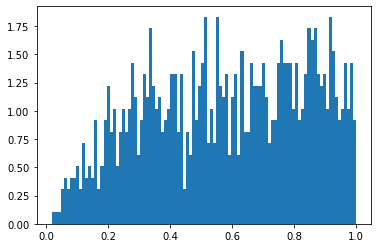

In [20]:
# график pvalue в 1000 симуляций 
plt.hist(fpr_ttest['pvalue'], bins = 100, density=True)
plt.show()

# Повторим на датафрейме где rides != 0 

In [21]:
df_for_ttest_wo_0 = df_for_ttest[df_for_ttest['y'] != 0]

In [22]:
# fpr на 1000 симуляций

fpr_wo_0 = pd.DataFrame(columns=['pvalue', 'lift', 'lb', 'ub'])

for sim in range(1000):

    df_0 = df_for_ttest_wo_0.sample(n=int(round(len(df_for_ttest_wo_0['y'])*0.5)) , replace=False)
    df_1 = df_for_ttest_wo_0.sample(n=int(round(len(df_for_ttest_wo_0['y'])*0.5)) , replace=False)

    pvalue, lift, lb, ub = t_test_ratio(df_0, df_1)

    fpr_wo_0= fpr_wo_0.append({'pvalue':pvalue,
                      'lift':lift, 'lb':lb, 'ub':ub}, ignore_index=True)

0.5800746658572553
0.831464802915741
0.16332815928879812
0.8837916121466831
0.24258710986973042
0.7835324437814974
0.29104305600473185
0.6621674881310513
0.48929278217394667
0.7353928591477688
0.7062119851791442
0.6682440581936211
0.8883990130606534
0.43680162596283123
0.9014195247237566
0.5230057354672502
0.32449659789831886
0.5201701664509415
0.586177697234328
0.18848729702915615
0.9296347314205409
0.986846378141093
0.7832801716631446
0.9269139910633749
0.9663702303609492
0.3199205874264486
0.8635890208690826
0.21450094609855908
0.8922643443771233
0.616392127761626
0.8027081819031037
0.4659262517025997
0.815623857563917
0.3586525017664848
0.9439926017852347
0.17395106253364861
0.8667537581499217
0.8026000692749047
0.08329878726829928
0.31938563928869235
0.6057841406240269
0.9329839485622451
0.7829665661503771
0.9916825073560049
0.8763804490683285
0.9081435257095043
0.23187537323377344
0.052274930240949063
0.444482827160676
0.6538053515156842
0.4359497813300386
0.23648442493422178
0.2

0.5198583349990531
0.7454617875329124
0.16238649979804076
0.3685236180174263
0.33051060442471236
0.35820307019363706
0.7768020883860612
0.9294741628494414
0.534361389133202
0.4817068426208905
0.9923768205867107
0.4755736921659198
0.2992686517809237
0.03937683502679475
0.7556703200927734
0.41473858481036907
0.8338587995574716
0.5032802974067987
0.4727451326321158
0.9335377695300355
0.21167619023178388
0.9730895046609107
0.6347872400216319
0.5489142726723859
0.8704974303797084
0.72557447967081
0.9672721672274189
0.9026430535976369
0.950763312292568
0.5350715310605374
0.11130742302317255
0.32660646182819897
0.9618118637161399
0.39994787439010426
0.8176630166901379
0.6255612028323154
0.9345868923203033
0.3845826889070352
0.45182178888488767
0.7400796580544391
0.9051661756575211
0.9100819939706026
0.10426502608554972
0.37863303188340847
0.41557471445192407
0.5442149229371323
0.15914037768608316
0.8797953557590508
0.40141059329831985
0.33180217155737535
0.5709725628121787
0.3620069362099858


0.10529071928372966
0.34354131396661425
0.25407279097066376
0.21501142686009378
0.2954698403351569
0.39101226015629087
0.49601754089070416
0.7380593774273105
0.4726006519850571
0.442614782698729
0.5771158664467757
0.8303535547439402
0.7917422707010373
0.5182860232167322
0.7862653330512268
0.8127417918497224
0.7569991221743584
0.5543067672756459
0.9727607383574849
0.8943054956405743
0.18177475008356397
0.593409862439333
0.5165831452739493
0.7495354635956104
0.18309910082269656
0.9205279567342288
0.9948745234283658
0.5697358493143578
0.8718555523755255
0.9302335748660143
0.8812022291603175
0.2856473877369173
0.7337221563101168
0.36509904389126135
0.8343501387078989
0.1886688678988435
0.6973772475716324
0.9655131847676145
0.8110383580875951
0.3517013804259552
0.44316272374636323
0.1437561294430292
0.11194626599392168
0.47311748407300147
0.7779659463834439
0.6343409624438581
0.6466008512736023
0.8157713674435083
0.44964924933713835
0.05416750038925788
0.15656987086509316
0.3855741031285626

In [23]:
fpr_wo_0

,pvalue,lift,lb,ub
0,0.580075,-0.694236,-3.153722,1.765250
1,0.831465,-0.166225,-1.697145,1.364696
2,0.163328,-1.664947,-4.006023,0.676130
3,0.883792,-0.221072,-3.185678,2.743533
4,0.242587,-1.374558,-3.680195,0.931080
...,...,...,...,...
995,0.421345,0.607616,-0.873525,2.088756
996,0.197232,1.529552,-0.795436,3.854539
997,0.966863,-0.052071,-2.508931,2.404790
998,0.750039,0.378366,-1.949556,2.706288


In [24]:
fpr_wo_0[fpr_wo_0['pvalue'] < 0.05]

,pvalue,lift,lb,ub
443,0.039377,2.401983,0.116917,4.687049
563,0.045901,2.363144,0.043029,4.683259


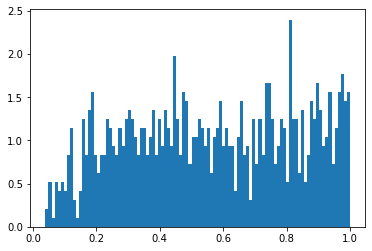

In [25]:
# график pvalue в 1000 симуляций 
plt.hist(fpr_wo_0['pvalue'], bins = 100, density=True)
plt.show()

FPR такой же, как в исходном dataframe

Слишком мало ложных прокрасов -- возможно, применение этого оценщика к этой метрике будет давать большую ошибку второго рода. Стоит проверить, как покажут себя другие оценщики

# Пуассоновский бутстрап

In [26]:
BOOT_ITERATIONS = 1000

In [27]:
df_for_poisson = df_for_ttest[df_for_ttest['y'] != 0]

In [28]:
df_for_poisson

,id_client,x,y,n
0,0,267.418467,247,1
1,66670,-24.847217,4,1
6,590729,-58.277033,2,1
7,601277,9.591150,1,1
8,627131,-147.328517,3,1
...,...,...,...,...
43492,168258091,-9.098950,1,1
43493,168258207,34.140833,1,1
43497,168258515,36.000000,1,1
43499,168258859,-39.319917,1,1


In [29]:
def poisson_bootstrap(df_0, df_1, boot_it = BOOT_ITERATIONS):

    x_0 = np.array(df_0['x'], dtype=np.float64)
    x_1 = np.array(df_1['x'], dtype=np.float64)
    y_0 = np.array(df_0['y'], dtype=np.float64)
    y_1 = np.array(df_1['y'], dtype=np.float64)

    rto0 = np.array([x_0 / y_0])
    rto1 = np.array([x_1 / y_1])

    poisson_0 = poisson(1).rvs((boot_it, rto0.size)).astype(np.int64)
    poisson_1 = poisson(1).rvs((boot_it, rto1.size)).astype(np.int64)

    rto0 = np.matmul(rto0 * y_0, poisson_0.T)
    w0 = np.matmul(y_0, poisson_0.T)
    rto1 = np.matmul(rto1 * y_1, poisson_1.T)
    w1 = np.matmul(y_1, poisson_1.T)

    delta = rto1 / w1 - rto0 / w0
    positions = np.sum(delta < 0)

    pvalue = 2 * np.minimum(positions, boot_it - positions) / boot_it
    return pvalue

In [30]:
# fpr на 1000 симуляций

fpr = pd.DataFrame(columns=['pvalue'])

for sim in range(1000):

    df_0 = df_for_poisson.sample(n=int(round(len(df_for_poisson['x'])*0.5)) , replace=False)
    df_1 = df_for_poisson.sample(n=int(round(len(df_for_poisson['x'])*0.5)) , replace=False)

    pvalue = poisson_bootstrap(df_0, df_1)

    fpr = fpr.append({'pvalue':pvalue}, ignore_index=True)
    
    print(pvalue)

0.6
0.668
0.762
0.458
0.774
0.148
0.956
0.93
0.842
0.412
0.194
0.348
0.192
0.384
0.82
0.168
0.974
0.794
0.718
0.92
0.284
0.72
0.804
0.558
0.774
0.968
0.672
0.762
0.962
0.464
0.664
0.356
0.564
0.398
0.544
0.456
0.414
0.528
0.948
0.76
0.552
0.62
0.116
0.248
0.488
0.682
0.456
0.614
0.586
0.472
0.818
0.904
0.634
0.342
0.908
0.222
0.452
0.186
0.242
0.874
0.738
0.866
0.544
0.552
0.712
0.828
0.606
0.142
0.432
0.344
0.75
0.734
0.23
0.298
0.99
0.758
0.312
0.126
0.2
0.932
0.792
0.622
0.258
0.962
0.534
0.432
0.652
0.672
0.8
0.946
0.222
0.304
0.664
0.958
0.616
0.344
0.116
0.762
0.336
0.856
0.706
0.18
0.876
0.986
0.524
0.856
0.83
0.834
0.972
0.226
0.93
0.79
0.46
0.568
0.71
0.576
0.894
0.882
0.86
0.346
0.768
0.326
0.79
0.226
0.632
0.578
0.376
0.798
0.73
0.672
0.206
0.994
0.762
0.702
0.496
0.504
0.712
0.454
0.224
0.434
0.942
0.972
0.716
0.882
0.34
0.884
0.82
0.97
0.622
0.602
0.792
0.44
0.458
0.364
0.438
0.196
0.766
0.252
0.984
0.716
0.24
0.546
0.458
0.176
0.638
0.628
0.982
0.75
0.916
0.676
0.886
0.79

In [31]:
fpr

,pvalue
0,0.600
1,0.668
2,0.762
3,0.458
4,0.774
...,...
995,0.680
996,0.326
997,0.240
998,0.770


In [32]:
fpr[fpr['pvalue'] < 0.05]

,pvalue
256,0.038
257,0.034
268,0.028
336,0.022
531,0.040
624,0.044
811,0.042
842,0.026
988,0.032


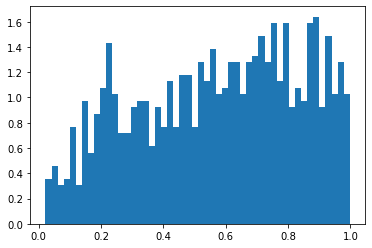

In [33]:
# график pvalue в 1000 симуляций 
plt.hist(fpr['pvalue'], bins = 50, density=True)
plt.show()

In [34]:
final = pd.DataFrame(columns = ['pval_ttest_ratio', 'pval_poisson'])

In [35]:
final['pval_poisson'] = fpr['pvalue']

In [36]:
final['pval_ttest_ratio'] = fpr_ttest['pvalue']

In [37]:
final = final.round(3)

In [38]:
final

,pval_ttest_ratio,pval_poisson
0,0.435,0.600
1,0.344,0.668
2,0.462,0.762
3,0.363,0.458
4,0.290,0.774
...,...,...
995,0.238,0.680
996,0.646,0.326
997,0.223,0.240
998,0.553,0.770


In [39]:
fpr_ttest = len(final[final['pval_ttest_ratio'] < 0.05])/1000
fpr_ttest

0.003

In [40]:
fpr_poisson = len(final[final['pval_poisson'] < 0.05])/1000
fpr_poisson

0.009